In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [3]:
anchor_mode = "model" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df_anchor, df_cm_anchor, df_db_anchor = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm_anchor['date_obj'] = pd.to_datetime(df_cm_anchor['date'])

# anchor_benchmark = "Winogrande"
# anchor_difficulty = 0
# anchor_slope = 1
# df_anchor, df_cm_anchor, df_db_anchor = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)

# # Convert date strings to datetime objects
# df_cm_anchor['date_obj'] = pd.to_datetime(df_cm_anchor['date'])

`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 3.4246e+01, final cost 2.4828e+00, first-order optimality 1.78e-04.


In [4]:
all_runs = {}           # will map benchmark_name -> dict of outputs
failed    = []          # keep track of anything that errors out

# --- loop --------------------------------------------------------------------
for _, row in df_db_anchor.iterrows():
    anchor_benchmark  = row['benchmark_name']       # e.g. "HellaSwag"
    anchor_difficulty = float(row['estimated_difficulty'])
    anchor_slope      = float(row['estimated_slope'])
    
    try:
        df, df_cm, df_db = fit_statistical_model(
            scores_df,
            anchor_mode="benchmark",
            anchor_benchmark  = anchor_benchmark,
            anchor_difficulty = anchor_difficulty,
            anchor_slope      = anchor_slope
        )
        all_runs[anchor_benchmark] = {
            "df1" : df,
            "df_cm1" : df_cm,
            "df_db" : df_db,
            # cache the anchor values for reference
            "anchor_difficulty" : anchor_difficulty,
            "anchor_slope"      : anchor_slope,
        }
    except Exception as e:
        failed.append((anchor_benchmark, str(e)))

# --- post-processing (optional) ----------------------------------------------
# 1) quick glance at what failed
if failed:
    print("Benchmarks that raised errors:", failed)

# 2) pull out the difficulty/slope re-estimates across all runs
summary = (
    pd.concat(
        {k: v["df_db"][["benchmark_name", "estimated_difficulty", "estimated_slope"]]
         for k, v in all_runs.items()},
        names=["anchor_benchmark"]
    )
    .reset_index(level=0)
)


`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 3.3915e+01, final cost 2.4254e+00, first-order optimality 1.12e-04.
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 3.3946e+01, final cost 2.4270e+00, first-order optimality 5.09e-05.
`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 3.3996e+01, final cost 2.4268e+00, first-order optimality 4.95e-04.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.3945e+01, final cost 2.4270e+00, first-order optimality 7.92e-05.
`ftol` termination condition is satisfied.
Function evaluations 30, initial cost 3.4094e+01, final cost 2.4247e+00, first-order optimality 3.41e-05.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.4081e+01, final cost 2.4246e+00, first-order optimality 2.21e-04.
`ftol` termination condition is satisfied.
Function evaluations 30, initial cost 3.4146e+01, final cost 2.

In [5]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------------
# 1)  DIFFICULTY  ––  variation of each benchmark’s difficulty estimate
# ---------------------------------------------------------------------------
difficulty_rows = []

for anchor, run in all_runs.items():
    df_db = run["df_db"]                                  # difficulty table from that fit
    out = df_db[["benchmark_name", "estimated_difficulty"]].copy()
    out["anchor_benchmark"] = anchor                      # remember which fit this came from
    difficulty_rows.append(out)

difficulty_long = pd.concat(difficulty_rows, ignore_index=True)

# drop the trivial row where the benchmark was forced to be the anchor (always fixed):
difficulty_long = difficulty_long[
    difficulty_long["benchmark_name"] != difficulty_long["anchor_benchmark"]
]

difficulty_stats = (
    difficulty_long
      .groupby("benchmark_name")["estimated_difficulty"]
      .agg(mean   = "mean",
           std    = "std",
           min    = "min",
           max    = "max",
           cv     = lambda s: s.std(ddof=0) / s.mean()      # coefficient of variation
      )
      .sort_index()
)

# ---------------------------------------------------------------------------
# 2)  CAPABILITY  ––  variation of each model’s capability estimate
# ---------------------------------------------------------------------------
capability_rows = []

for anchor, run in all_runs.items():
    df_cm = run["df_cm1"]                                  # capability table from that fit
    out = df_cm[["model", "estimated_capability"]].copy()
    out["anchor_benchmark"] = anchor
    capability_rows.append(out)

capability_long = pd.concat(capability_rows, ignore_index=True)

capability_stats = (
    capability_long
      .groupby("model")["estimated_capability"]
      .agg(mean = "mean",
           std  = "std",
           min  = "min",
           max  = "max",
           cv   = lambda s: s.std(ddof=0) / s.mean()
      )
      .sort_index()
)

# ---------------------------------------------------------------------------
# 3)  quick look
# ---------------------------------------------------------------------------
print("=== variation in benchmark difficulties ===")
display(difficulty_stats)

print("\n=== variation in model capabilities ===")
display(capability_stats)


=== variation in benchmark difficulties ===


,mean,std,min,max,cv
benchmark_name,,,,,
ANLI,0.879505,0.067812,0.630540,0.952880,0.075807
ARC AI2,0.074245,0.115938,-0.146989,0.198066,1.535318
ARC-AGI,2.068905,0.053815,1.814401,2.147912,0.025574
Aider polyglot,1.770756,0.053756,1.515033,1.834522,0.029848
BBH,0.468574,0.090208,0.233932,0.567482,0.189280
Balrog,2.450525,0.056428,2.198041,2.552235,0.022640
BoolQ,-1.123609,0.208504,-1.537819,-0.922035,-0.182447
CSQA2,0.085801,0.092002,-0.081500,0.192395,1.054255
CadEval,1.807249,0.053672,1.551749,1.872774,0.029199



=== variation in model capabilities ===


,mean,std,min,max,cv
model,,,,,
Baichuan-2-13B-Base,0.136867,0.113286,-0.081509,0.261958,0.814249
Baichuan-2-7B-Base,-0.054945,0.127712,-0.265558,0.083539,-2.286591
Cerebras-GPT-13B,-0.506247,0.164431,-0.798413,-0.335947,-0.319523
Chinchilla (70B),0.713319,0.075675,0.472465,0.798634,0.104364
DeepSeek-R1,1.800190,0.052852,1.544126,1.865246,0.028882
...,...,...,...,...,...
stablelm-tuned-alpha-7b,-0.825597,0.191350,-1.176695,-0.632813,-0.228003
text-davinci-001,0.289187,0.102725,0.065418,0.403878,0.349443
text-davinci-002,1.059209,0.059915,0.804349,1.120091,0.055646


In [8]:
# ---------------------------------------------------------------------------
# 4)  Rank correlation across fits (Spearman) for difficulties and capabilities
#     Robust to duplicates and missing values
# ---------------------------------------------------------------------------

def _spearman_corr_from_long(df_long: pd.DataFrame, index_col: str, columns_col: str, values_col: str) -> pd.DataFrame:
    # Allow duplicates by aggregating with mean; coerce to numeric in case of stray dtypes
    wide = df_long.pivot_table(
        index=index_col,
        columns=columns_col,
        values=values_col,
        aggfunc="mean",
    )
    wide = wide.apply(pd.to_numeric, errors="coerce")

    # Drop rows that are entirely NaN
    wide = wide.dropna(axis=0, how="all")

    # Need at least two fits (columns) to compute a correlation matrix
    if wide.shape[1] < 2:
        return pd.DataFrame()

    # Compute Spearman by ranking then applying Pearson correlation
    ranks = wide.rank(axis=0, method="average", na_option="keep")
    corr = ranks.corr(method="pearson", min_periods=2)
    return corr

print("=== Spearman rank correlation across fits (benchmark difficulties) ===")
spearman_difficulty = _spearman_corr_from_long(
    difficulty_long,
    index_col="benchmark_name",
    columns_col="anchor_benchmark",
    values_col="estimated_difficulty",
)
if spearman_difficulty.empty:
    print("Not enough comparable fits to compute correlations for difficulties.")
else:
    display(spearman_difficulty)
    mean_rho_difficulty = spearman_difficulty.apply(
        lambda s: s.drop(labels=s.name).mean(), axis=0
    ).sort_values(ascending=False).to_frame("mean_rho")
    print("\nMean off-diagonal Spearman per fit (difficulties):")
    display(mean_rho_difficulty)

print("\n=== Spearman rank correlation across fits (model capabilities) ===")
spearman_capability = _spearman_corr_from_long(
    capability_long,
    index_col="model",
    columns_col="anchor_benchmark",
    values_col="estimated_capability",
)
if spearman_capability.empty:
    print("Not enough comparable fits to compute correlations for capabilities.")
else:
    display(spearman_capability)
    mean_rho_capability = spearman_capability.apply(
        lambda s: s.drop(labels=s.name).mean(), axis=0
    ).sort_values(ascending=False).to_frame("mean_rho")
    print("\nMean off-diagonal Spearman per fit (capabilities):")
    display(mean_rho_capability)



=== Spearman rank correlation across fits (benchmark difficulties) ===


anchor_benchmark,ANLI,ARC AI2,ARC-AGI,Aider polyglot,BBH,Balrog,BoolQ,CSQA2,CadEval,Cybench,...,OTIS Mock AIME 2024-2025,OpenBookQA,SWE-Bench verified,SimpleBench,Terminal Bench,TriviaQA,VPCT,VideoMME,WeirdML,Winogrande
anchor_benchmark,,,,,,,,,,,,,,,,,,,,,
ANLI,1.000000,0.999291,0.998633,0.999141,1.000000,0.998510,0.999316,0.999192,0.998788,0.998503,...,0.998511,0.999426,0.998611,0.998364,0.998741,0.999132,0.998548,0.999136,0.998703,0.999527
ARC AI2,0.999291,1.000000,0.998198,0.998479,0.999436,0.998363,0.999437,1.000000,0.998285,0.998381,...,0.997926,1.000000,0.998520,0.998049,0.998656,0.999615,0.998371,0.999786,0.998444,0.999451
ARC-AGI,0.998633,0.998198,1.000000,0.999586,0.998497,0.998683,0.998788,0.998207,1.000000,0.998588,...,0.999340,0.998229,0.998521,0.999785,0.998562,0.998719,0.998809,0.998830,0.999141,0.999121
Aider polyglot,0.999141,0.998479,0.999586,1.000000,0.998960,0.998329,0.998836,0.998442,0.999785,0.998285,...,0.999555,0.998555,0.998322,0.999234,0.998417,0.998908,0.998405,0.998972,0.998639,0.999121
BBH,1.000000,0.999436,0.998497,0.998960,1.000000,0.998443,0.999321,0.999312,0.998639,0.998444,...,0.998346,0.999596,0.998567,0.998255,0.998703,0.999197,0.998472,0.999230,0.998606,0.999500
Balrog,0.998510,0.998363,0.998683,0.998329,0.998443,1.000000,0.999107,0.998413,0.998555,1.000000,...,0.997987,0.998346,0.999609,0.998974,0.999477,0.998643,1.000000,0.998504,0.999596,0.999454
BoolQ,0.999316,0.999437,0.998788,0.998836,0.999321,0.999107,1.000000,0.999516,0.998809,0.999106,...,0.998360,0.999384,0.999171,0.998734,0.999250,0.999788,0.999121,0.999630,0.999171,1.000000
CSQA2,0.999192,1.000000,0.998207,0.998442,0.999312,0.998413,0.999516,1.000000,0.998280,0.998431,...,0.997904,0.999786,0.998564,0.998079,0.998693,0.999787,0.998419,1.000000,0.998483,0.999480
CadEval,0.998788,0.998285,1.000000,0.999785,0.998639,0.998555,0.998809,0.998280,1.000000,0.998479,...,0.999555,0.998329,0.998451,0.999587,0.998513,0.998778,0.998664,0.998876,0.998960,0.999129



Mean off-diagonal Spearman per fit (difficulties):


,mean_rho
anchor_benchmark,
OSUniverse,0.999434
Winogrande,0.999434
GSO-Bench,0.999232
BoolQ,0.999232
Factorio learning environment,0.999089
HellaSwag,0.999089
TriviaQA,0.999084
DeepResearch Bench,0.999073
VideoMME,0.999063



=== Spearman rank correlation across fits (model capabilities) ===


anchor_benchmark,ANLI,ARC AI2,ARC-AGI,Aider polyglot,BBH,Balrog,BoolQ,CSQA2,CadEval,Cybench,...,OTIS Mock AIME 2024-2025,OpenBookQA,SWE-Bench verified,SimpleBench,Terminal Bench,TriviaQA,VPCT,VideoMME,WeirdML,Winogrande
anchor_benchmark,,,,,,,,,,,,,,,,,,,,,
ANLI,1.000000,0.999872,0.999940,0.999911,0.999890,0.999943,0.999904,0.999947,0.999936,0.999943,...,0.999929,0.999900,0.999943,0.999932,0.999940,0.999950,0.999943,0.999947,0.999929,0.999893
ARC AI2,0.999872,1.000000,0.999858,0.999840,0.999986,0.999847,0.999975,0.999844,0.999865,0.999840,...,0.999883,0.999979,0.999840,0.999851,0.999844,0.999947,0.999840,0.999844,0.999858,0.999986
ARC-AGI,0.999940,0.999858,1.000000,0.999957,0.999872,0.999989,0.999908,0.999986,0.999982,0.999982,...,0.999975,0.999868,0.999982,0.999979,0.999986,0.999925,0.999982,0.999986,0.999975,0.999893
Aider polyglot,0.999911,0.999840,0.999957,1.000000,0.999854,0.999961,0.999883,0.999957,0.999979,0.999961,...,0.999961,0.999851,0.999964,0.999975,0.999961,0.999904,0.999954,0.999957,0.999975,0.999872
BBH,0.999890,0.999986,0.999872,0.999854,1.000000,0.999861,0.999968,0.999858,0.999879,0.999854,...,0.999897,0.999975,0.999854,0.999865,0.999858,0.999964,0.999854,0.999858,0.999872,0.999989
Balrog,0.999943,0.999847,0.999989,0.999961,0.999861,1.000000,0.999900,0.999996,0.999986,0.999993,...,0.999979,0.999858,0.999993,0.999982,0.999989,0.999918,0.999993,0.999996,0.999979,0.999883
BoolQ,0.999904,0.999975,0.999908,0.999883,0.999968,0.999900,1.000000,0.999897,0.999911,0.999893,...,0.999929,0.999964,0.999893,0.999900,0.999897,0.999961,0.999893,0.999897,0.999904,0.999986
CSQA2,0.999947,0.999844,0.999986,0.999957,0.999858,0.999996,0.999897,1.000000,0.999982,0.999996,...,0.999975,0.999854,0.999996,0.999979,0.999993,0.999915,0.999996,1.000000,0.999975,0.999879
CadEval,0.999936,0.999865,0.999982,0.999979,0.999879,0.999986,0.999911,0.999982,1.000000,0.999979,...,0.999986,0.999876,0.999986,0.999982,0.999982,0.999929,0.999979,0.999982,0.999972,0.999900



Mean off-diagonal Spearman per fit (capabilities):


,mean_rho
anchor_benchmark,
GPQA diamond,0.999961
OSWorld,0.999960
Balrog,0.999959
VideoMME,0.999958
GeoBench,0.999958
DeepResearch Bench,0.999958
GSO-Bench,0.999958
FrontierMath-2025-02-28-Private,0.999958
Factorio learning environment,0.999958


In [9]:
all_runs = {}           # will map model_pair -> dict of outputs
failed    = []          # keep track of anything that errors out

# --- Create model pairs for anchoring -------------------------------------
# Get unique models with their estimated capabilities
models_with_capability = df_cm_anchor[['model', 'estimated_capability']].drop_duplicates()
models_list = models_with_capability.to_dict('records')

# Create pairs of models to use as anchors
# You can adjust this logic based on your needs
model_pairs = []
for i in range(len(models_list) - 1):
    # Each model paired with the next one
    model_pairs.append((models_list[i], models_list[i + 1]))
    
# Alternatively, you could pair each model with a fixed reference model:
# reference_model = models_list[0]  # or find a specific model
# model_pairs = [(reference_model, model) for model in models_list[1:]]

# --- loop over model pairs ------------------------------------------------
for model1_info, model2_info in model_pairs:
    anchor_model1 = model1_info['model']
    anchor_model1_capability = float(model1_info['estimated_capability'])
    anchor_model2 = model2_info['model']
    anchor_model2_capability = float(model2_info['estimated_capability'])
    
    # Create a key for storing results
    pair_key = f"{anchor_model1}_{anchor_model2}"
    
    try:
        df, df_cm, df_db = fit_statistical_model(
            scores_df,
            anchor_mode="model",
            anchor_benchmark=anchor_benchmark,  # Keep the same benchmark
            anchor_difficulty=anchor_difficulty,  # Keep the same difficulty
            anchor_slope=anchor_slope,          # Keep the same slope
            anchor_model1=anchor_model1,
            anchor_model1_capability=anchor_model1_capability,
            anchor_model2=anchor_model2,
            anchor_model2_capability=anchor_model2_capability
        )
        
        all_runs[pair_key] = {
            "df1": df,
            "df_cm1": df_cm,
            "df_db": df_db,
            # cache the anchor values for reference
            "anchor_model1": anchor_model1,
            "anchor_model1_capability": anchor_model1_capability,
            "anchor_model2": anchor_model2,
            "anchor_model2_capability": anchor_model2_capability,
        }
    except Exception as e:
        failed.append((pair_key, str(e)))

# --- post-processing (optional) ----------------------------------------------
# 1) quick glance at what failed
if failed:
    print("Model pairs that raised errors:", failed)

# 2) pull out the model capability estimates across all runs
summary_models = pd.concat(
    {k: v["df_cm1"][["model", "estimated_capability"]]
     for k, v in all_runs.items()},
    names=["anchor_model_pair"]
).reset_index(level=0)

# 3) pull out the benchmark difficulty/slope estimates across all runs
summary_benchmarks = pd.concat(
    {k: v["df_db"][["benchmark_name", "estimated_difficulty", "estimated_slope"]]
     for k, v in all_runs.items()},
    names=["anchor_model_pair"]
).reset_index(level=0)

print(f"Processed {len(all_runs)} model pair combinations")
print(f"Failed: {len(failed)} combinations")

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.3672e+01, final cost 2.5757e+00, first-order optimality 7.42e-05.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.3849e+01, final cost 2.5774e+00, first-order optimality 9.07e-05.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.3905e+01, final cost 2.5777e+00, first-order optimality 2.53e-04.
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.3986e+01, final cost 2.5791e+00, first-order optimality 3.92e-04.
`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 3.3994e+01, final cost 2.5796e+00, first-order optimality 9.97e-05.
`ftol` termination condition is satisfied.
Function evaluations 35, initial cost 3.3557e+01, final cost 2.5788e+00, first-order optimality 6.74e-05.
`ftol` termination condition is satisfied.
Function evaluations 30, initial cost 3.3932e+01, final cost 2.

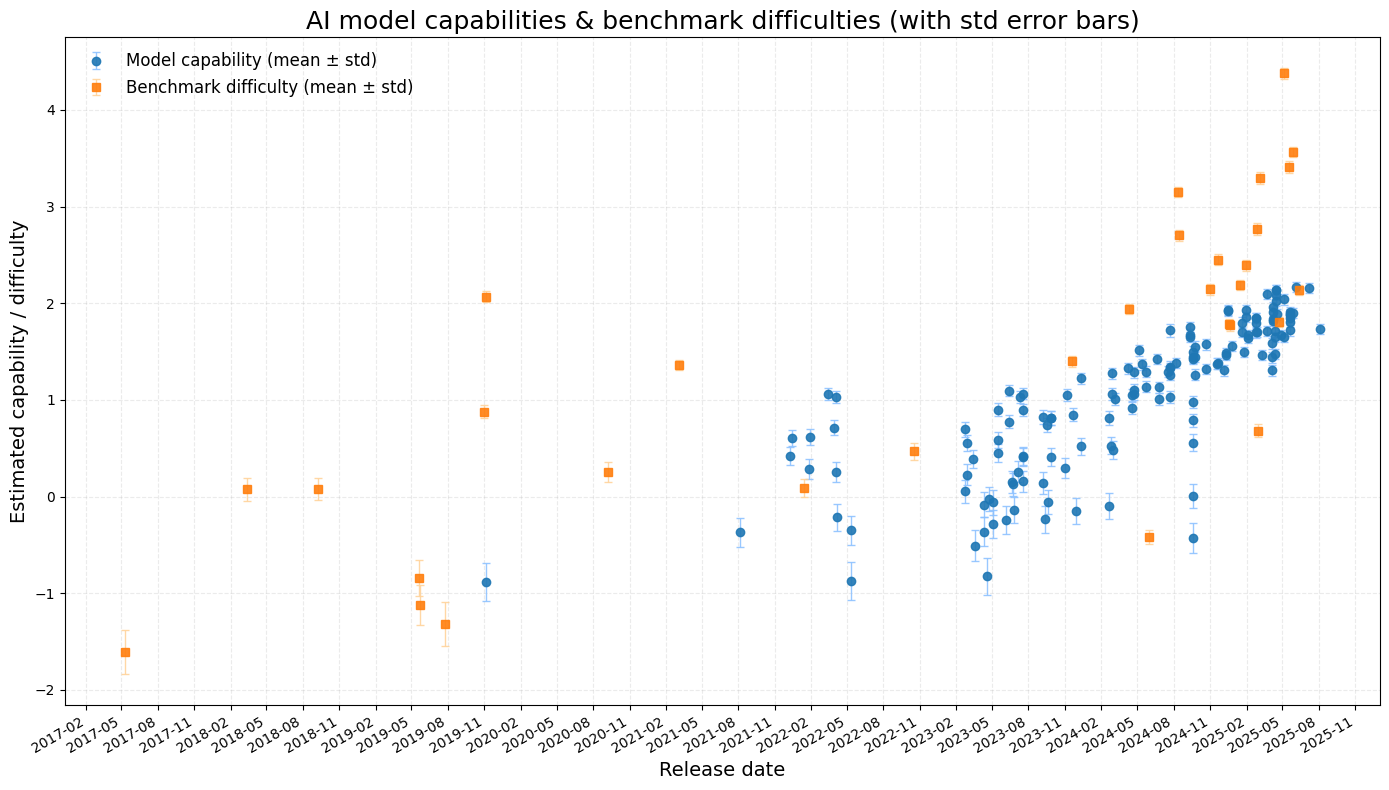

In [6]:
# Capabilities and difficulties over time with std error bars (from variation tables)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Expect these to exist from earlier cells:
# - capability_stats: index=model, columns include ['mean','std']
# - difficulty_stats: index=benchmark_name, columns include ['mean','std']
# - df_cm_anchor: per-model table with 'model' and 'date' (string) or 'date_obj'
# - df_db_anchor: per-benchmark table with 'benchmark_name' and 'benchmark_release_date'

# Merge stats with model release dates
cap_stats_df = capability_stats.reset_index()  # 'model', 'mean', 'std', ...
model_dates = df_cm_anchor[["model", "date"]].drop_duplicates(subset=["model"]).copy()
model_dates["date_obj"] = pd.to_datetime(model_dates["date"], errors="coerce")
cap_plot_df = (
    cap_stats_df.merge(model_dates, on="model", how="left")
    .dropna(subset=["date_obj", "mean"])  # require a date and mean
    .sort_values("date_obj")
)
cap_plot_df["std"] = cap_plot_df["std"].fillna(0.0)

# Merge stats with benchmark release dates
diff_stats_df = difficulty_stats.reset_index()  # 'benchmark_name', 'mean', 'std', ...
bench_dates = df_db_anchor[["benchmark_name", "benchmark_release_date"]].drop_duplicates(subset=["benchmark_name"]).copy()
bench_dates["benchmark_release_date"] = pd.to_datetime(bench_dates["benchmark_release_date"], errors="coerce")
diff_plot_df = (
    diff_stats_df.merge(bench_dates, on="benchmark_name", how="left")
    .dropna(subset=["benchmark_release_date", "mean"])  # require a date and mean
    .sort_values("benchmark_release_date")
)
diff_plot_df["std"] = diff_plot_df["std"].fillna(0.0)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

ax.errorbar(
    cap_plot_df["date_obj"],
    cap_plot_df["mean"],
    yerr=cap_plot_df["std"],
    fmt="o",
    color="tab:blue",
    ecolor="#8ec2ff",
    elinewidth=1,
    capsize=3,
    alpha=0.9,
    label="Model capability (mean ± std)"
)

ax.errorbar(
    diff_plot_df["benchmark_release_date"],
    diff_plot_df["mean"],
    yerr=diff_plot_df["std"],
    fmt="s",
    color="tab:orange",
    ecolor="#ffd39b",
    elinewidth=1,
    capsize=3,
    alpha=0.9,
    label="Benchmark difficulty (mean ± std)"
)

ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties (with std error bars)", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

ax.grid(True, alpha=0.25, linestyle='--')
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()



In [10]:
# ---------------------------------------------------------------------------
# 1)  DIFFICULTY  ––  variation of each benchmark's difficulty estimate
#     across different model anchor pairs
# ---------------------------------------------------------------------------
difficulty_rows = []

for anchor_pair, run in all_runs.items():
    df_db = run["df_db"]                                  # difficulty table from that fit
    out = df_db[["benchmark_name", "estimated_difficulty"]].copy()
    out["anchor_model_pair"] = anchor_pair                # remember which model pair this came from
    # Also store the individual models for more detailed analysis if needed
    out["anchor_model1"] = run["anchor_model1"]
    out["anchor_model2"] = run["anchor_model2"]
    difficulty_rows.append(out)

difficulty_long = pd.concat(difficulty_rows, ignore_index=True)

# No need to drop trivial rows since we're not anchoring on benchmarks
# All benchmark estimates are free to vary

difficulty_stats = (
    difficulty_long
      .groupby("benchmark_name")["estimated_difficulty"]
      .agg(mean   = "mean",
           std    = "std",
           min    = "min",
           max    = "max",
           count  = "count",                              # how many model pairs estimated this
           cv     = lambda s: s.std(ddof=0) / s.mean() if s.mean() != 0 else np.nan
      )
      .sort_index()
)

# ---------------------------------------------------------------------------
# 2)  CAPABILITY  ––  variation of each model's capability estimate
#     across different model anchor pairs
# ---------------------------------------------------------------------------
capability_rows = []

for anchor_pair, run in all_runs.items():
    df_cm = run["df_cm1"]                                 # capability table from that fit
    # Check the actual column name - might be 'model' or 'model_name'
    model_col = "model_name" if "model_name" in df_cm.columns else "model"
    out = df_cm[[model_col, "estimated_capability"]].copy()
    out.rename(columns={model_col: "model"}, inplace=True)  # standardize column name
    out["anchor_model_pair"] = anchor_pair
    # Also store the individual anchor models
    out["anchor_model1"] = run["anchor_model1"]
    out["anchor_model2"] = run["anchor_model2"]
    capability_rows.append(out)

capability_long = pd.concat(capability_rows, ignore_index=True)

# For model capabilities, we might want to exclude rows where the model 
# was one of the anchors (since those were fixed)
capability_long_free = capability_long[
    (capability_long["model"] != capability_long["anchor_model1"]) &
    (capability_long["model"] != capability_long["anchor_model2"])
]

# Stats for all models (including anchored ones)
capability_stats_all = (
    capability_long
      .groupby("model")["estimated_capability"]
      .agg(mean  = "mean",
           std   = "std",
           min   = "min",
           max   = "max",
           count = "count",
           cv    = lambda s: s.std(ddof=0) / s.mean() if s.mean() != 0 else np.nan
      )
      .sort_index()
)

# Stats for non-anchored models only (more meaningful variation)
capability_stats_free = (
    capability_long_free
      .groupby("model")["estimated_capability"]
      .agg(mean  = "mean",
           std   = "std",
           min   = "min",
           max   = "max",
           count = "count",
           cv    = lambda s: s.std(ddof=0) / s.mean() if s.mean() != 0 else np.nan
      )
      .sort_index()
)

# ---------------------------------------------------------------------------
# 3)  SLOPE  ––  variation of each benchmark's slope estimate
# ---------------------------------------------------------------------------
slope_rows = []

for anchor_pair, run in all_runs.items():
    df_db = run["df_db"]
    out = df_db[["benchmark_name", "estimated_slope"]].copy()
    out["anchor_model_pair"] = anchor_pair
    slope_rows.append(out)

slope_long = pd.concat(slope_rows, ignore_index=True)

slope_stats = (
    slope_long
      .groupby("benchmark_name")["estimated_slope"]
      .agg(mean  = "mean",
           std   = "std",
           min   = "min",
           max   = "max",
           count = "count",
           cv    = lambda s: s.std(ddof=0) / s.mean() if s.mean() != 0 else np.nan
      )
      .sort_index()
)

# ---------------------------------------------------------------------------
# 4)  Quick look at results
# ---------------------------------------------------------------------------
print("=== Variation in benchmark difficulties across model anchor pairs ===")
display(difficulty_stats)

print("\n=== Variation in benchmark slopes across model anchor pairs ===")
display(slope_stats)

print("\n=== Variation in model capabilities (all models) ===")
display(capability_stats_all)

print("\n=== Variation in model capabilities (excluding anchored models) ===")
display(capability_stats_free)

# ---------------------------------------------------------------------------
# 5)  Additional analysis: which model pairs give most stable estimates?
# ---------------------------------------------------------------------------
# Calculate overall stability metric for each model pair
stability_by_pair = {}

for anchor_pair in all_runs.keys():
    # Get difficulty variations for this pair
    diff_subset = difficulty_long[difficulty_long["anchor_model_pair"] == anchor_pair]
    cap_subset = capability_long_free[capability_long_free["anchor_model_pair"] == anchor_pair]
    
    # Calculate average deviation from overall means
    diff_devs = []
    for bench in diff_subset["benchmark_name"].unique():
        estimate = diff_subset[diff_subset["benchmark_name"] == bench]["estimated_difficulty"].iloc[0]
        overall_mean = difficulty_stats.loc[bench, "mean"]
        diff_devs.append(abs(estimate - overall_mean))
    
    cap_devs = []
    for model in cap_subset["model"].unique():
        if model in capability_stats_free.index:
            estimate = cap_subset[cap_subset["model"] == model]["estimated_capability"].iloc[0]
            overall_mean = capability_stats_free.loc[model, "mean"]
            cap_devs.append(abs(estimate - overall_mean))
    
    stability_by_pair[anchor_pair] = {
        "mean_difficulty_deviation": np.mean(diff_devs) if diff_devs else np.nan,
        "mean_capability_deviation": np.mean(cap_devs) if cap_devs else np.nan,
        "combined_deviation": np.mean(diff_devs + cap_devs) if (diff_devs or cap_devs) else np.nan
    }

stability_df = pd.DataFrame(stability_by_pair).T.sort_values("combined_deviation")

print("\n=== Model pair stability (lower deviation = more stable) ===")
display(stability_df.head(10))  # Show top 10 most stable pairs

=== Variation in benchmark difficulties across model anchor pairs ===


,mean,std,min,max,count,cv
benchmark_name,,,,,,
ANLI,0.576904,0.171304,0.148446,0.853594,149,0.295938
ARC AI2,-0.031989,0.221886,-0.572622,0.263367,149,-6.913003
ARC-AGI,1.948494,0.273432,1.213769,2.212920,149,0.139858
Aider polyglot,1.614525,0.237116,0.937043,1.854031,149,0.146371
BBH,0.324886,0.180106,-0.148678,0.584454,149,0.552502
Balrog,2.368297,0.332024,1.558319,2.714604,149,0.139724
BoolQ,-1.218257,0.447152,-2.080091,-0.602495,149,-0.365809
CSQA2,-0.329824,0.161517,-0.760793,-0.125501,149,-0.488062
CadEval,1.653583,0.240238,0.970420,1.892235,149,0.144795



=== Variation in benchmark slopes across model anchor pairs ===


,mean,std,min,max,count,cv
benchmark_name,,,,,,
ANLI,0.949958,0.247404,0.676248,1.395438,149,0.259561
ARC AI2,1.511995,0.411552,1.070354,2.288111,149,0.271277
ARC-AGI,4.478621,0.708559,2.984404,5.299933,149,0.157677
Aider polyglot,3.244570,0.554589,2.250287,3.901585,149,0.170354
BBH,1.433160,0.386742,0.993533,2.153350,149,0.268945
Balrog,1.090131,0.187621,0.755459,1.317417,149,0.171531
BoolQ,1.008272,0.274833,0.720922,1.546536,149,0.271662
CSQA2,0.326550,0.048583,0.255513,0.427432,149,0.148275
CadEval,2.272964,0.388145,1.568320,2.734986,149,0.170192



=== Variation in model capabilities (all models) ===


,mean,std,min,max,count,cv
model,,,,,,
Baichuan-2-13B-Base,0.022723,0.215473,-0.510097,0.304139,149,9.450721
Baichuan-2-7B-Base,-0.163597,0.243944,-0.731591,0.166295,149,-1.486114
Cerebras-GPT-13B,-0.587071,0.319552,-1.252025,-0.146496,149,-0.542487
Chinchilla (70B),0.474530,0.172668,0.028658,0.738817,149,0.362649
DeepSeek-R1,1.647710,0.240956,0.963706,1.887455,149,0.145745
...,...,...,...,...,...,...
stablelm-tuned-alpha-7b,-0.880515,0.377027,-1.638438,-0.363670,149,-0.426750
text-davinci-001,0.011444,0.215855,-0.521015,0.295527,149,18.798225
text-davinci-002,0.743699,0.174332,0.279800,1.019313,149,0.233624



=== Variation in model capabilities (excluding anchored models) ===


,mean,std,min,max,count,cv
model,,,,,,
Baichuan-2-13B-Base,0.019426,0.215056,-0.510097,0.304139,147,11.033022
Baichuan-2-7B-Base,-0.166798,0.244040,-0.731591,0.166295,147,-1.458106
Cerebras-GPT-13B,-0.590008,0.320727,-1.252025,-0.146496,147,-0.541745
Chinchilla (70B),0.471035,0.171192,0.028658,0.738817,147,0.362200
DeepSeek-R1,1.645051,0.241504,0.963706,1.887455,147,0.146307
...,...,...,...,...,...,...
stablelm-tuned-alpha-7b,-0.883271,0.378849,-1.638438,-0.363670,147,-0.427455
text-davinci-001,0.008153,0.215451,-0.521015,0.295527,147,26.337233
text-davinci-002,0.740088,0.172714,0.279800,1.019313,147,0.232574



=== Model pair stability (lower deviation = more stable) ===


,mean_difficulty_deviation,mean_capability_deviation,combined_deviation
Mixtral-8x7B-v0.1_text-davinci-002,0.060466,0.028353,0.033914
Qwen2.5-Coder-14B_falcon-180B,0.070134,0.035910,0.041837
gpt-3.5-turbo-0613_internlm-20b,0.085505,0.047437,0.054030
falcon-180B_gpt-3.5-turbo-0613,0.082704,0.053932,0.058914
internlm-20b_Qwen2.5-Coder-32B,0.097957,0.056632,0.063789
text-davinci-002_Qwen2.5-Coder-14B,0.109445,0.072264,0.078703
Qwen2.5-Coder-32B_Qwen-14B,0.119925,0.083617,0.089905
Phi-3-mini-4k-instruct_PaLM 2-L,0.125860,0.094214,0.099695
Chinchilla (70B)_Qwen2.5-Coder-7B,0.151842,0.090167,0.100849
Qwen2.5-Coder-7B_PaLM 540B,0.180110,0.117983,0.128742


In [12]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------------
# Spearman rank correlation across anchor model pairs
# - Difficulties (by benchmark)
# - Capabilities (by model)
# Robust to duplicates and missing values
# ---------------------------------------------------------------------------

def _spearman_corr_from_long(df_long: pd.DataFrame, index_col: str, columns_col: str, values_col: str) -> pd.DataFrame:
    wide = df_long.pivot_table(
        index=index_col,
        columns=columns_col,
        values=values_col,
        aggfunc="mean",
    )
    wide = wide.apply(pd.to_numeric, errors="coerce").dropna(axis=0, how="all")
    if wide.shape[1] < 2:
        return pd.DataFrame()
    ranks = wide.rank(axis=0, method="average", na_option="keep")
    return ranks.corr(method="pearson", min_periods=2)

# --- Difficulties across anchor model pairs ---------------------------------
print("=== Spearman across anchor model pairs (benchmark difficulties) ===")
spearman_difficulty_pairs = _spearman_corr_from_long(
    summary_benchmarks.rename(columns={"anchor_model_pair": "anchor"}),
    index_col="benchmark_name",
    columns_col="anchor",
    values_col="estimated_difficulty",
)
if spearman_difficulty_pairs.empty:
    print("Not enough comparable fits to compute correlations for difficulties across model pairs.")
else:
    display(spearman_difficulty_pairs)
    mean_rho_difficulty_pairs = spearman_difficulty_pairs.apply(
        lambda s: s.drop(labels=s.name).mean(), axis=0
    ).sort_values(ascending=False).to_frame("mean_rho")
    print("\nMean off-diagonal Spearman per model-pair fit (difficulties):")
    display(mean_rho_difficulty_pairs)

# --- Capabilities across anchor model pairs ---------------------------------
print("\n=== Spearman across anchor model pairs (model capabilities) ===")
spearman_capability_pairs = _spearman_corr_from_long(
    summary_models.rename(columns={"anchor_model_pair": "anchor"}),
    index_col="model",
    columns_col="anchor",
    values_col="estimated_capability",
)
if spearman_capability_pairs.empty:
    print("Not enough comparable fits to compute correlations for capabilities across model pairs.")
else:
    display(spearman_capability_pairs)
    mean_rho_capability_pairs = spearman_capability_pairs.apply(
        lambda s: s.drop(labels=s.name).mean(), axis=0
    ).sort_values(ascending=False).to_frame("mean_rho")
    print("\nMean off-diagonal Spearman per model-pair fit (capabilities):")
    display(mean_rho_capability_pairs)



=== Spearman across anchor model pairs (benchmark difficulties) ===


anchor,Baichuan-2-13B-Base_text-davinci-001,Baichuan-2-7B-Base_vicuna-13b-v1.1,Cerebras-GPT-13B_stablelm-tuned-alpha-7b,Chinchilla (70B)_Qwen2.5-Coder-7B,DeepSeek-R1-0528_claude-opus-4-20250514_16K,DeepSeek-R1_claude-3-7-sonnet-20250219_16K,DeepSeek-V2_Qwen2.5-72B,DeepSeek-V3-0324_gpt-4.1-2025-04-14,DeepSeek-V3_gemini-1.5-pro-002,GLaM (MoE)_LLaMA-33B,...,phi-2_Llama-2-34b,phi-4_gpt-4.1-nano-2025-04-14,qwen-max-2025-01-25_phi-4,qwen2.5-72b-instruct_Llama-4-Scout-17B-16E-Instruct,qwen3-235b-a22b_gemini-2.0-pro-exp-02-05,stablelm-tuned-alpha-7b_opt-1.3b,text-davinci-001_mpt-30b,text-davinci-002_Qwen2.5-Coder-14B,vicuna-13b-v1.1_gemma-2b,xgen-7b-8k-base_Llama-2-7b
anchor,,,,,,,,,,,,,,,,,,,,,
Baichuan-2-13B-Base_text-davinci-001,1.000000,0.999597,0.999194,0.997984,0.995161,0.994758,0.995161,0.995161,0.995161,0.999597,...,0.999597,0.995161,0.995161,0.996774,0.994758,0.999194,1.000000,0.996774,0.999597,0.999597
Baichuan-2-7B-Base_vicuna-13b-v1.1,0.999597,1.000000,0.999597,0.997177,0.994355,0.993952,0.994355,0.994355,0.994355,0.999194,...,0.999194,0.994355,0.994355,0.995968,0.993952,0.999597,0.999597,0.995968,1.000000,1.000000
Cerebras-GPT-13B_stablelm-tuned-alpha-7b,0.999194,0.999597,1.000000,0.997984,0.995968,0.995565,0.995968,0.995968,0.995968,0.999597,...,0.999597,0.995968,0.995968,0.997177,0.995565,1.000000,0.999194,0.997177,0.999597,0.999597
Chinchilla (70B)_Qwen2.5-Coder-7B,0.997984,0.997177,0.997984,1.000000,0.998790,0.998387,0.998790,0.998790,0.998790,0.998790,...,0.998790,0.998790,0.998790,0.999597,0.998387,0.997984,0.997984,0.999597,0.997177,0.997177
DeepSeek-R1-0528_claude-opus-4-20250514_16K,0.995161,0.994355,0.995968,0.998790,1.000000,0.999597,1.000000,1.000000,1.000000,0.996774,...,0.996774,1.000000,1.000000,0.999597,0.999597,0.995968,0.995161,0.999597,0.994355,0.994355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stablelm-tuned-alpha-7b_opt-1.3b,0.999194,0.999597,1.000000,0.997984,0.995968,0.995565,0.995968,0.995968,0.995968,0.999597,...,0.999597,0.995968,0.995968,0.997177,0.995565,1.000000,0.999194,0.997177,0.999597,0.999597
text-davinci-001_mpt-30b,1.000000,0.999597,0.999194,0.997984,0.995161,0.994758,0.995161,0.995161,0.995161,0.999597,...,0.999597,0.995161,0.995161,0.996774,0.994758,0.999194,1.000000,0.996774,0.999597,0.999597
text-davinci-002_Qwen2.5-Coder-14B,0.996774,0.995968,0.997177,0.999597,0.999597,0.999194,0.999597,0.999597,0.999597,0.997984,...,0.997984,0.999597,0.999597,1.000000,0.999194,0.997177,0.996774,1.000000,0.995968,0.995968



Mean off-diagonal Spearman per model-pair fit (difficulties):


,mean_rho
anchor,
claude-3-opus-20240229_Llama-3.2-90B-Vision-Instruct,0.998660
qwen2.5-72b-instruct_Llama-4-Scout-17B-16E-Instruct,0.998660
Mixtral-8x7B-v0.1_text-davinci-002,0.998660
Llama-3.1-70B-Instruct_StableBeluga2,0.998660
Llama-3.2-90B-Vision-Instruct_Llama-3.1-70B-Instruct,0.998660
...,...
gpt-j-6b_LLaMA-7B,0.996464
gpt-neox-20b_open_llama_7b,0.996464
gemma-2b_xgen-7b-8k-base,0.996464



=== Spearman across anchor model pairs (model capabilities) ===


anchor,Baichuan-2-13B-Base_text-davinci-001,Baichuan-2-7B-Base_vicuna-13b-v1.1,Cerebras-GPT-13B_stablelm-tuned-alpha-7b,Chinchilla (70B)_Qwen2.5-Coder-7B,DeepSeek-R1-0528_claude-opus-4-20250514_16K,DeepSeek-R1_claude-3-7-sonnet-20250219_16K,DeepSeek-V2_Qwen2.5-72B,DeepSeek-V3-0324_gpt-4.1-2025-04-14,DeepSeek-V3_gemini-1.5-pro-002,GLaM (MoE)_LLaMA-33B,...,phi-2_Llama-2-34b,phi-4_gpt-4.1-nano-2025-04-14,qwen-max-2025-01-25_phi-4,qwen2.5-72b-instruct_Llama-4-Scout-17B-16E-Instruct,qwen3-235b-a22b_gemini-2.0-pro-exp-02-05,stablelm-tuned-alpha-7b_opt-1.3b,text-davinci-001_mpt-30b,text-davinci-002_Qwen2.5-Coder-14B,vicuna-13b-v1.1_gemma-2b,xgen-7b-8k-base_Llama-2-7b
anchor,,,,,,,,,,,,,,,,,,,,,
Baichuan-2-13B-Base_text-davinci-001,1.000000,0.999940,0.999911,0.999417,0.999716,0.999648,0.993223,0.999605,0.999492,0.999829,...,0.999783,0.999460,0.999470,0.999442,0.999410,0.999844,0.999972,0.998254,0.999932,0.999932
Baichuan-2-7B-Base_vicuna-13b-v1.1,0.999940,1.000000,0.999950,0.999253,0.999652,0.999570,0.992764,0.999516,0.999378,0.999758,...,0.999669,0.999328,0.999346,0.999314,0.999342,0.999929,0.999929,0.997987,0.999979,0.999986
Cerebras-GPT-13B_stablelm-tuned-alpha-7b,0.999911,0.999950,1.000000,0.999246,0.999655,0.999577,0.992739,0.999520,0.999385,0.999708,...,0.999623,0.999335,0.999353,0.999321,0.999346,0.999936,0.999897,0.997952,0.999943,0.999964
Chinchilla (70B)_Qwen2.5-Coder-7B,0.999417,0.999253,0.999246,1.000000,0.999420,0.999438,0.994563,0.999438,0.999396,0.999488,...,0.999637,0.999424,0.999435,0.999388,0.999307,0.999068,0.999392,0.998414,0.999246,0.999275
DeepSeek-R1-0528_claude-opus-4-20250514_16K,0.999716,0.999652,0.999655,0.999420,1.000000,0.999950,0.993635,0.999932,0.999872,0.999666,...,0.999716,0.999812,0.999822,0.999776,0.999772,0.999584,0.999691,0.998176,0.999644,0.999662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stablelm-tuned-alpha-7b_opt-1.3b,0.999844,0.999929,0.999936,0.999068,0.999584,0.999495,0.992163,0.999428,0.999271,0.999602,...,0.999492,0.999204,0.999225,0.999189,0.999243,1.000000,0.999829,0.997678,0.999922,0.999947
text-davinci-001_mpt-30b,0.999972,0.999929,0.999897,0.999392,0.999691,0.999623,0.993194,0.999580,0.999467,0.999808,...,0.999762,0.999431,0.999442,0.999413,0.999385,0.999829,1.000000,0.998226,0.999922,0.999922
text-davinci-002_Qwen2.5-Coder-14B,0.998254,0.997987,0.997952,0.998414,0.998176,0.998158,0.994421,0.998208,0.998275,0.998435,...,0.998585,0.998315,0.998325,0.998290,0.998108,0.997678,0.998226,1.000000,0.997980,0.997984



Mean off-diagonal Spearman per model-pair fit (capabilities):


,mean_rho
anchor,
o1-mini-2024-09-12_high_claude-opus-4-1-20250805,0.999630
claude-3-7-sonnet-20250219_16K_o1-mini-2024-09-12_high,0.999630
grok-3-beta_claude-opus-4-20250514,0.999628
o1-mini-2024-09-12_medium_qwen3-235b-a22b,0.999627
grok-3-mini-beta_low_grok-3-beta,0.999625
...,...
gpt-3.5-turbo-0613_internlm-20b,0.998529
Qwen2.5-Coder-14B_falcon-180B,0.998440
text-davinci-002_Qwen2.5-Coder-14B,0.998211
